### 다양한 모델을 결합한 앙상블
- 앙상블
- 다수결 두표 앙상블(Voting)
- 배깅(Bagging)
- 에이다부스트(AdaBost)
- 그레이던트 부스팅 & XGBoost
- 모델성능 평가 및 비교

- 단일모델의 한계
    - 과대적합(Overfitting) :  학습데이터에 너무 맞춰져있어서 새로운 데이터에 대한 성능저하
    - 과소적합(Underfitting) : 모델이 너무 단순해서 제대로 학습이 안됨
    - 높은 분산(Hight Variance) : 학습데이터가 조금만 바꿔도 모델이 크게 달라지는 현상
    - 높은 편향(High Bias) :  모델이 진짜 패턴을 포착하지 못함
- 앙상블( 집단지성 )    
    - 배깅   :  같은 알고리즘, 다른 데이터셋(부트스트랩)     RandomFores            분산 감소
    - 부스팅 :  순차적으로 약한 학습기를 강화              AdaBoost ,XGBoost        편향 감소    
    - 스태깅 :  다른알고리즘을 메타 모델로 학습                                     일반화 성능

- Voting
    - Hard Voting : 다수결 투표
        A : 고양이
        B : 강아지
        C : 고양이
    - Soft Voting : 가중치 투표 - 확률을 보고 결정  보통 Hard Voing 보다 성능이 좋음
        고양이, 강아지
        A : (0.9,0.1)
        B : (0.4,0.6)
        C : (0.6,0.2)
        평균확률 :   ,  
- Bagging( Bagging - Bootstrap Aggregation)
    - Bootstrap : 원본 데이터 1000 이면 중복을 허용해서 1000뽑아 훈련세트1를 만듦 ....
    - Aggregation
        - 순차적으로 학습을 하고난후 여러개의 모델들을  투표(Voting)해서 최종결론
    - 대표모델은 RandomForest
    - 효과 : 과적합을 방지 즉 모델의 분산을 줄여줌
- Bosting
    - 모델들이 순서대로 학습, 앞 모델의 실수를 뒷 모델이 보완
        - 모델1 전체 데이터로 학습하고 예측
        - 모델1 틀린 문제를 찾는다
        - 틀린문제를 더 높은 가중치(중요도)를 부여
        - 모델2 틀리기 쉬운문제들을 좀더 학습
        - 모델2 틀린 문제를 찾는다
        - 모델3 모델1+2가 틀린문제에 집중 -- 가중치 부여
        - 반복
    - 결론
        - 예측을 합친다 성적이 더 좋은 모델의 가중치를 부여해서 최종 결론
        - 편향을 줄여준다 Bias
- 스태킹
    - 1 base model : 여러개의 모델을 훈련
    - 2 meta model
        - 1단계 모델들이 예측한 값들을 모음
        - 예측한 값을 훈련데이터(특성)로 사용
    - 결론
        새로운데이터를 최종모델(Meta-Model)(예 로지스틱회귀)를 이용해서 결론을 도출






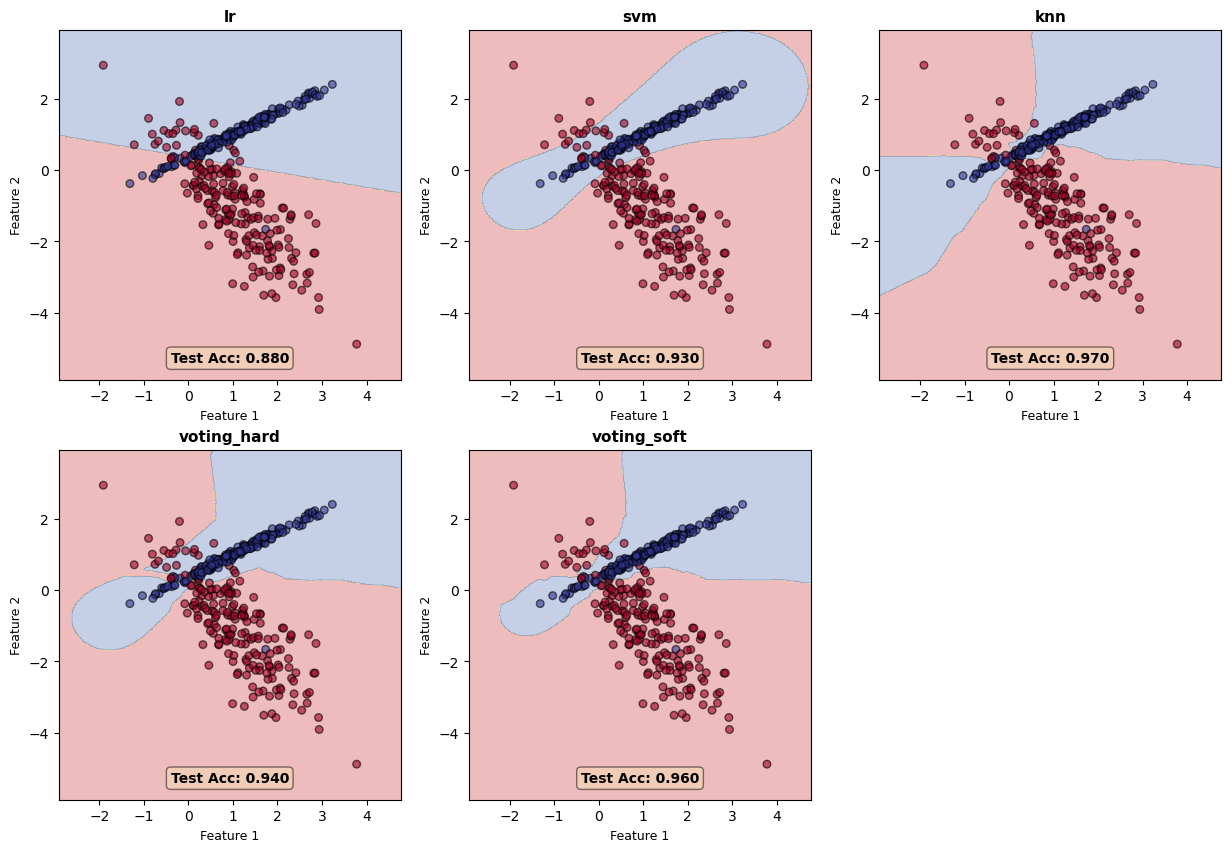

In [1]:
# 데이터 생성
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
import matplotlib.pylab as plt

X,y =  make_classification(n_samples=500, n_features=2,random_state=42,n_redundant=0,n_clusters_per_class=1)
np.unique(y,return_counts=True), X.shape
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# 개별모델 생성 학습
lr = LogisticRegression(random_state=42)
svm = SVC(random_state=42,probability=True)
knn = KNeighborsClassifier()
lr.fit(x_train,y_train) ; svm.fit(x_train,y_train) ; knn.fit(x_train,y_train)


# 보팅 앙상블
voting_hard = VotingClassifier(estimators=[('lr',lr),('svm',svm),('knn',knn)],voting='hard')
voting_soft = VotingClassifier(estimators=[('lr',lr),('svm',svm),('knn',knn)],voting='soft')

voting_hard.fit(x_train, y_train)
voting_soft.fit(x_train, y_train)

models  = [
    ('lr',lr),
    ('svm',svm),
    ('knn',knn),
    ('voting_hard',voting_hard),
    ('voting_soft',voting_soft)
           ]

# 결정 경계 시각화
def plot_decision_boundary(model, X, y, title, ax):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu,
              edgecolor='black', s=30, alpha=0.6)
    ax.set_title(title, fontsize=11, weight='bold')
    ax.set_xlabel('Feature 1', fontsize=9)
    ax.set_ylabel('Feature 2', fontsize=9)

# 5개 서브플롯 생성
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for idx, (title ,model) in enumerate(models):
  row = idx // 3
  col = idx % 3
  plot_decision_boundary(model, x_train, y_train, title, axes[row, col])

  # 정확도 표시
  score = model.score(x_test, y_test)
  axes[row, col].text(0.5, 0.05, f'Test Acc: {score:.3f}',
                      transform=axes[row, col].transAxes,
                      ha='center', fontsize=10, weight='bold',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 마지막 서브플롯 제거
axes[1, 2].remove()

In [2]:
# 질문 : 어떤 종류의 모델들을 조합하면?
# 다양성이 중요 : 서로다른 가정을 가진 모델 조합
# 선형모델 + 비선형모델 + 인스턴스기반(KNN)

#### 베깅
 - Bootstrap Aggreating
 - 같은 알고리즘을 다른데이터셋(부트스트랩 샘플)로 여러번 학습시켜 결합
 - Random Forest

In [3]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

(178, 13) (178,)


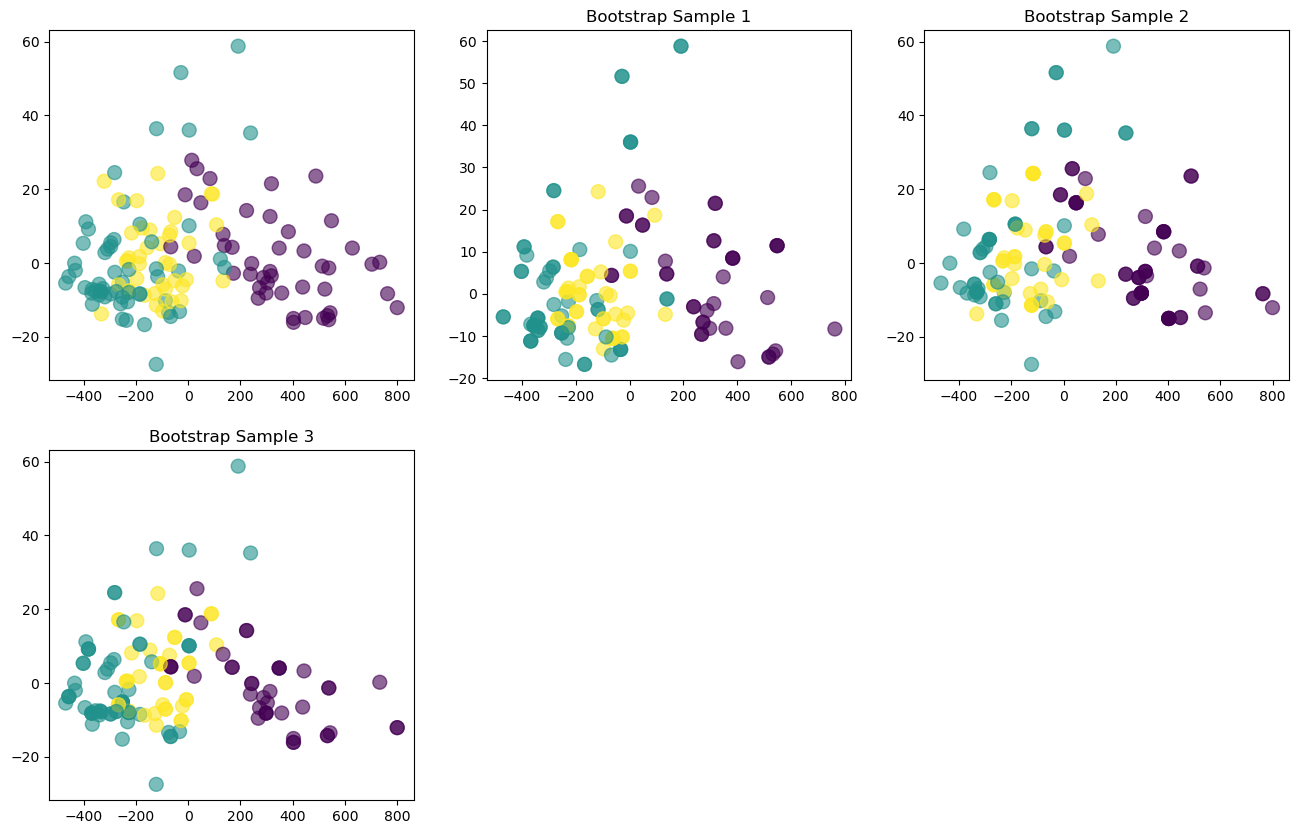

In [4]:
X, y = load_wine(return_X_y=True)
print(X.shape, y.shape)

# 시각화를 위해서
X_pca = PCA(n_components=2, random_state=42).fit_transform(X)

# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

#모델정의
tree = DecisionTreeClassifier(random_state=42)
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(),
                            n_estimators=100, random_state=42)
# 학습
tree.fit(x_train, y_train)
bagging.fit(x_train, y_train)

fig =  plt.figure(figsize=(16, 10))
# 1,원본데이터
ax1 =  plt.subplot(2,3,1)
ax1.scatter(x_train[:,0], x_train[:,1], c = y_train,s=100,alpha = 0.6, cmap='viridis')

# 부트스트랩 샘플3
np.random.seed(42)
for i in range(3):
  ax = plt.subplot(2,3,i+2)
  # 부트스트랩 샘플링
  n_samples = len(x_train)
  bootstrap_index = np.random.choice(n_samples, size=n_samples, replace=True)
  x_boot = x_train[bootstrap_index]
  y_boot = y_train[bootstrap_index]
  ax.scatter(x_boot[:,0], x_boot[:,1], c = y_boot,s=100,alpha = 0.6, cmap='viridis')
  ax.set_title(f'Bootstrap Sample {i+1}')

plt.show()

#### 에이다 부스트(AdaBoost)
 - 약한 학습기들을 순차적으로 결합해서 강한 학습기를 만듦
    - 이전 모델이 틀린 샘플에 더 집중
    - 각 모델은 이전 모델의 실수를 보완
    - 편향감소가 주요 목표
- 베깅 VS 부스팅
    학습방식  병렬(독립적)  / 순차적(의존성)
    샘플      부트스트랩   /  가중치 조정
    대표    RandomForest    AdaBoost, GradientBoosting, XGBoost
- 작동원리  AdaBoost
    - 모든 샘플에 동일한 가중치 부여
    - 약한 학습기 학습
    - 잘못 분류된 샘플의 가중치 증가
    - 반복
    - 최종적으로 모든 학습기를 가중 투표로 결합

KeyboardInterrupt: 

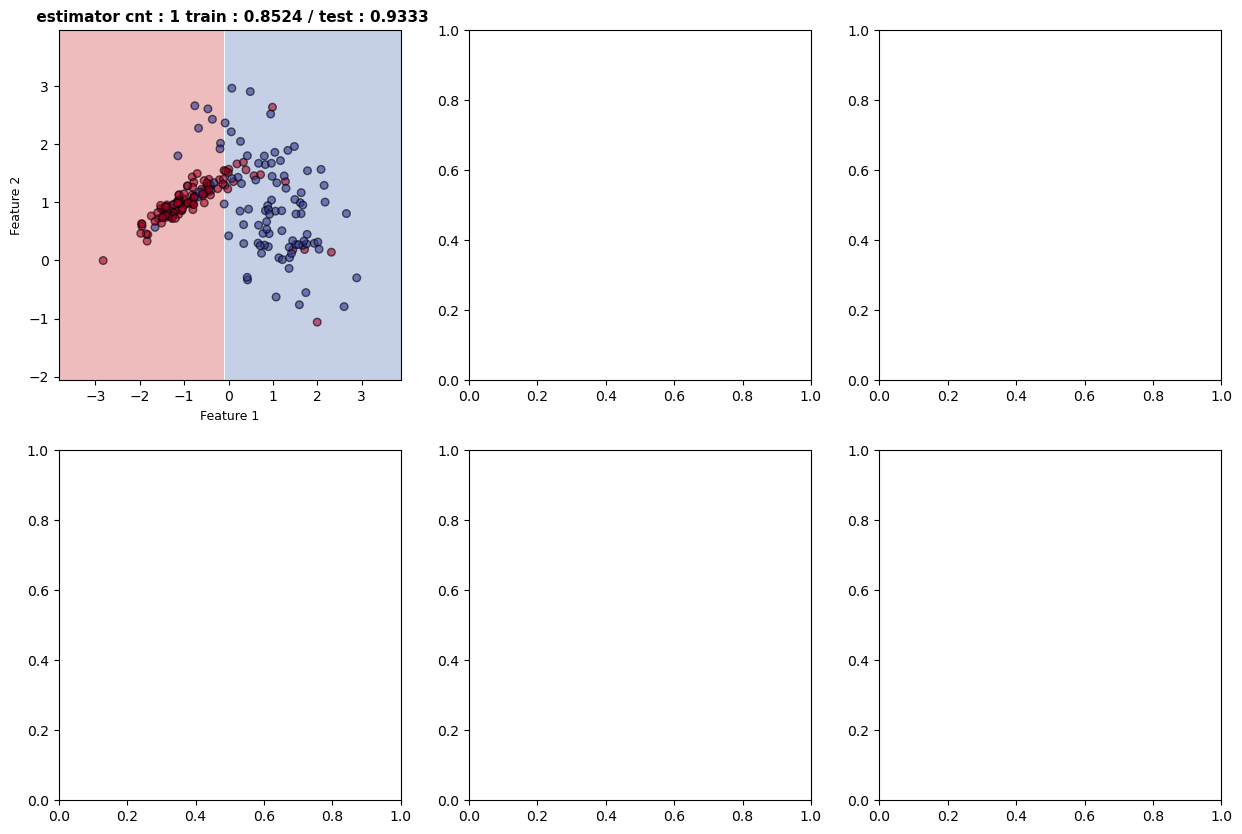

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report

np.random.seed(42)
X,y = make_classification(n_samples = 300, n_features=2, n_redundant=0,n_informative=2, 
n_clusters_per_class=1, flip_y=0.1,random_state=42)

x_train,x_test,y_train,y_test =  train_test_split(X,y,test_size=0.3, random_state=42)

fig,axes = plt.subplots(2,3,figsize=(15,10))
n_estimators_lists = [1,10,50,100,500]

for idx, n_est in enumerate(n_estimators_lists):
    ada =  AdaBoostClassifier(
        estimator = DecisionTreeClassifier(max_depth=1),
        n_estimators = n_est,
        learning_rate = 1.0,
        random_state = 42
    )
    ada.fit(x_train, y_train)

    # print(classification_report(y_test, ada.predict(x_test))   )
    title = f' estimator cnt : {n_est} train : {ada.score(x_train,y_train):.4f} / test : { ada.score(x_test, y_test):.4f}' 
    # print( title  )

    # 결정경계    
    plot_decision_boundary(ada, x_train, y_train, title, axes[idx // 3 , idx % 3 ])

    # 학습곡선
    train_score, test_score = [],[]
    for n in range(1,51):
        temp = AdaBoostClassifier(
        estimator = DecisionTreeClassifier(max_depth=1),
        n_estimators = n,
        learning_rate = 1.0,
        random_state = 42
        )
        temp.fit(x_train, y_train)
        train_score.append(temp.score(x_train, y_train))
        test_score.append(temp.score(x_test, y_test))
    axes[1,2].plot(range(1,501),train_score,label = 'train accuracy', marker='o')
    axes[1,2].plot(range(1,501),test_score,label = 'test accuracy', marker='s')
    axes[1,2].legend()
    